In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import os,sys
sys.path.append(os.path.abspath('./')) #for import utility.py
from utility import plot_confusion_matrix,plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

### 讀取資料

In [3]:
df = pd.read_csv("calories.csv")
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0


### 男女數據分布直方圖

In [5]:
def distribution_by_gender(item):
    male_ages = df[df["Gender"] == "male"][f"{item}"]
    female_ages = df[df["Gender"] == "female"][f"{item}"]
    
    # 繪製直方圖，使用不同顏色
    plt.figure(figsize=(10, 6))
    plt.hist(
        [male_ages, female_ages],  # 傳入兩組數據
        bins=12,                   # 設定 12 個區間
        color=["blue", "pink"],     # 設定顏色
        edgecolor="black",
        alpha=0.7,
        label=["Male", "Female"],
        # stacked=True                # **堆疊顯示**
    )
    
    # 加入標籤與標題
    plt.xlabel(f"{item}")
    plt.ylabel("Number of People")
    plt.title(f"{item} Distribution by Gender")
    plt.legend()  # 顯示圖例
    plt.grid(axis="y", linestyle="--", alpha=0.7)  # 加入網格線

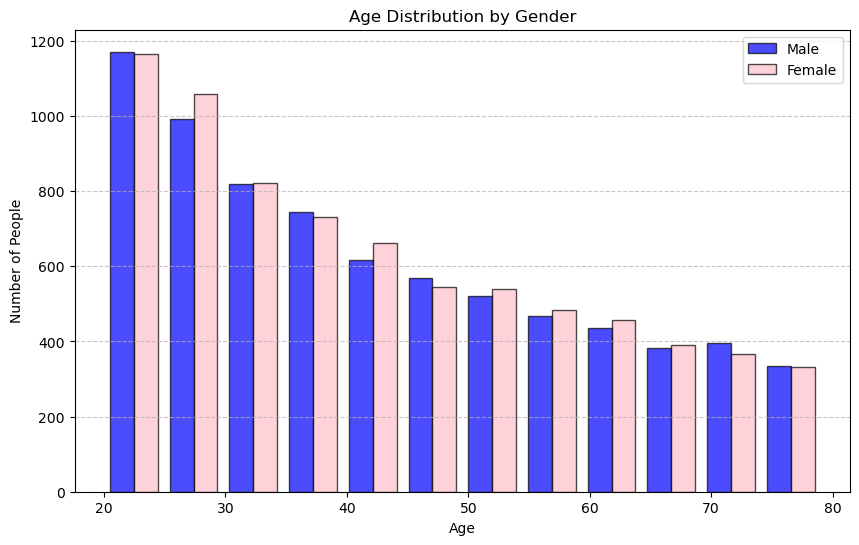

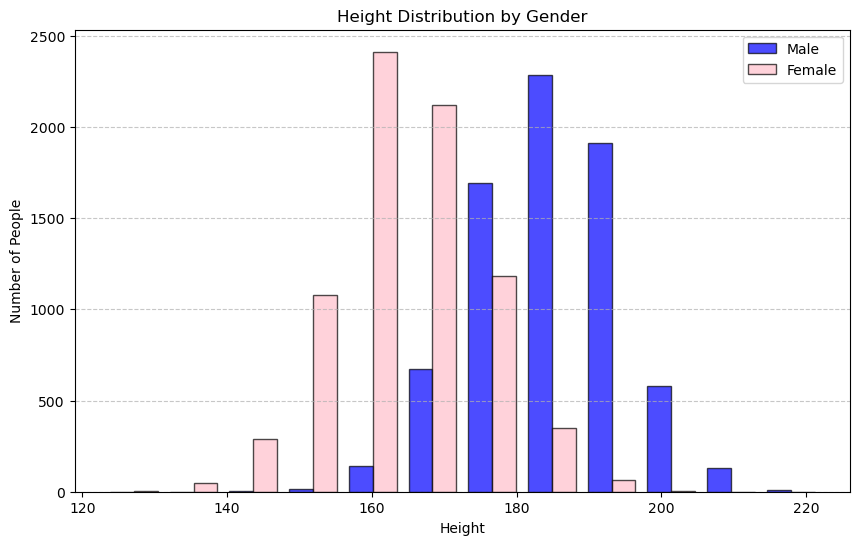

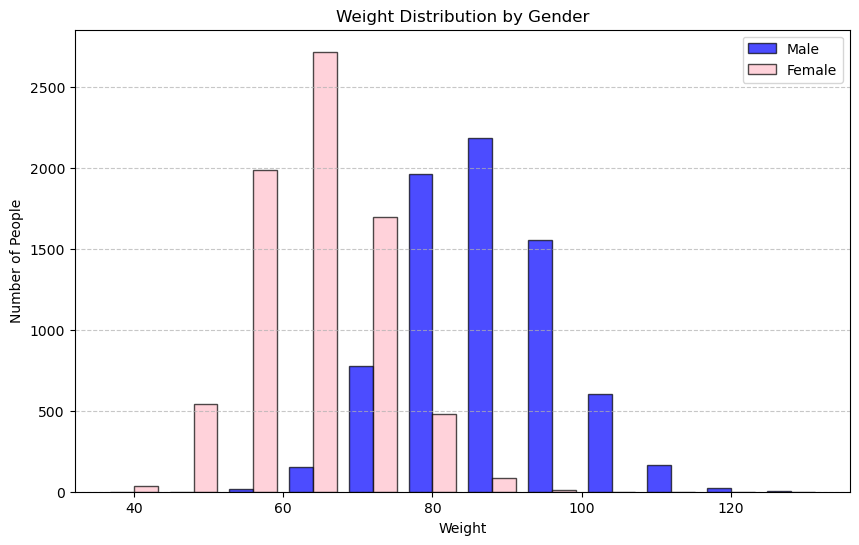

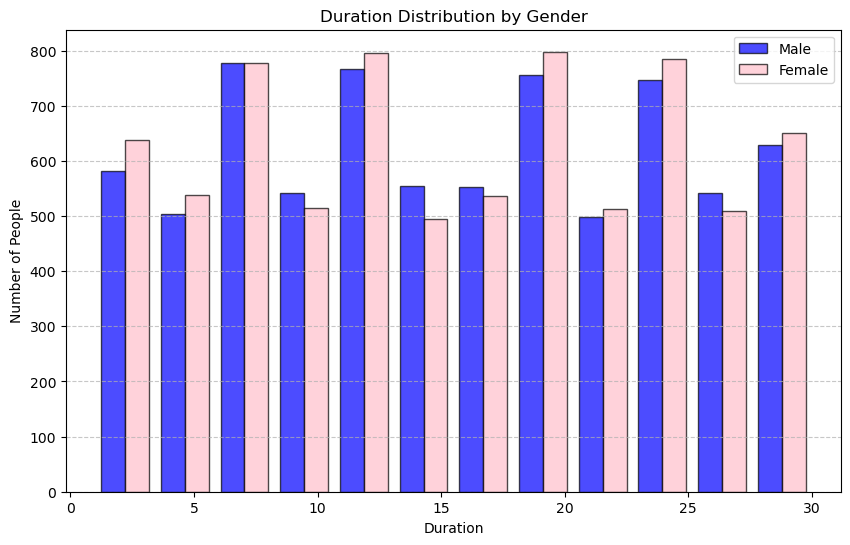

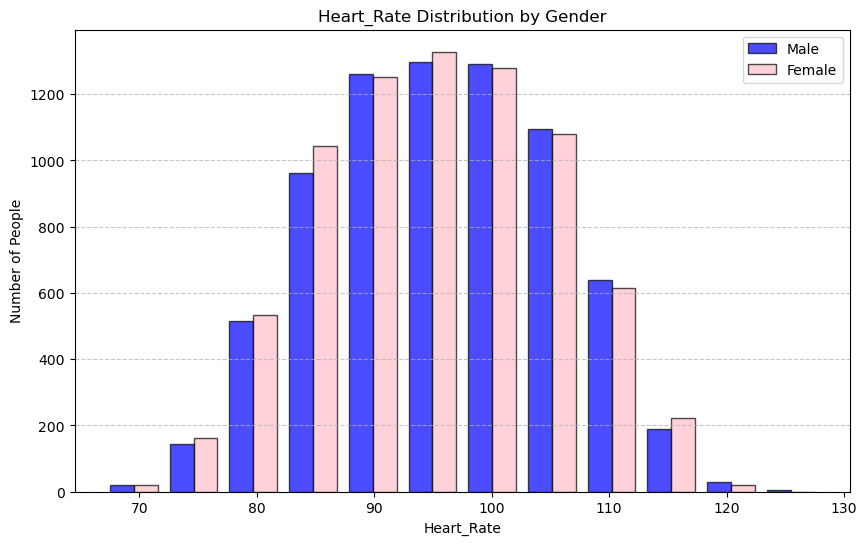

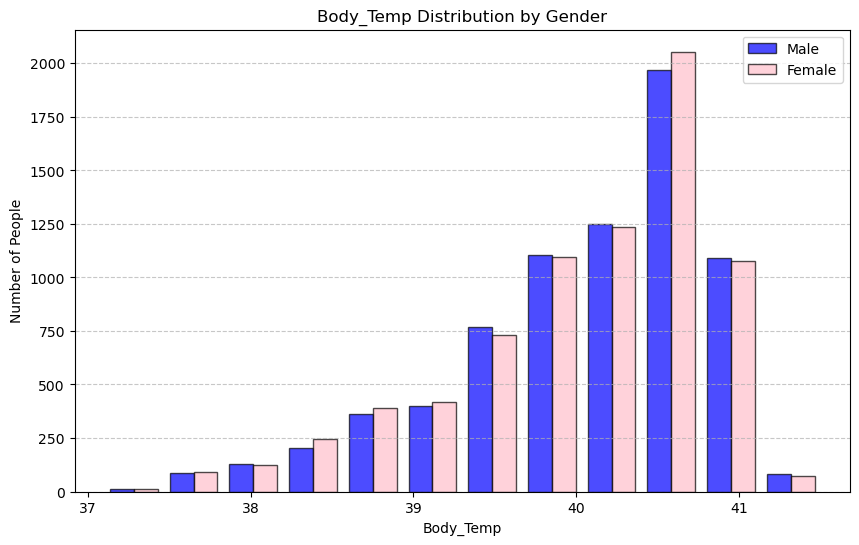

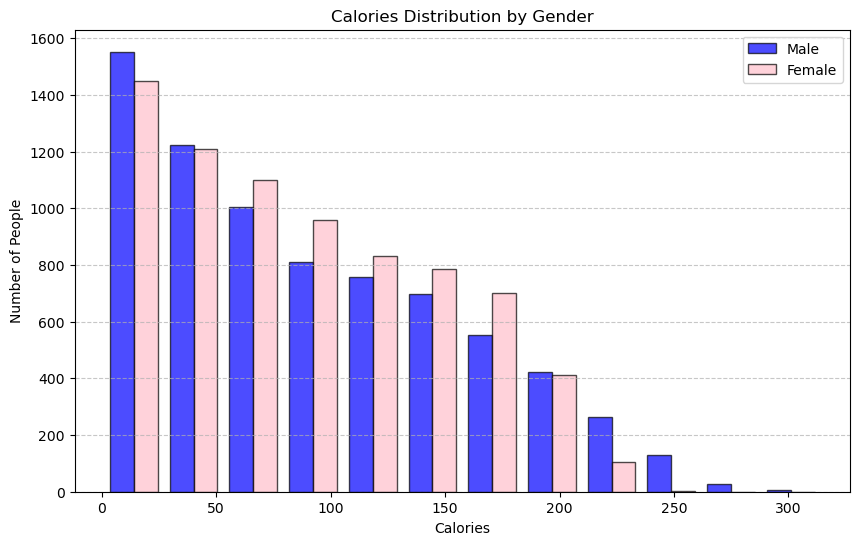

In [6]:
# 分別篩選男性與女性的數據
distribution_by_gender("Age")
distribution_by_gender("Height")
distribution_by_gender("Weight")
distribution_by_gender("Duration")
distribution_by_gender("Heart_Rate")
distribution_by_gender("Body_Temp")
distribution_by_gender("Calories")

由以上分布圖看出男性的身高以及體重平均大於女性

### 處理資料

加入BMI 跟   
Heavy_level = 2 太重   
Heavy_level = 1 過重   
Heavy_level = 0 正常   
將卡路里大於一百的值標示為1 小於的為0

In [10]:
df2 = df.replace(to_replace={"male":1, "female":0})
df2['BMI'] = round(df2.Weight/((df2.Height*0.01)**2),2)
df2['Heavy_level'] = df2['BMI'] >= 24
df2['Too_Heavy'] = df2['BMI'] >= 27
df2['Burn_level'] = df2.Calories > 100
df2 = df2.replace(to_replace={True:1, False:0})
df2['Heavy_level'] = df2['Heavy_level'] + df2['Too_Heavy']
df2 = df2.drop(["User_ID","Too_Heavy","BMI"], axis=1)
df2

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Heavy_level,Burn_level
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0,1,1
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0,0,0
2,1,69,179.0,79.0,5.0,88.0,38.7,26.0,1,0
3,0,34,179.0,71.0,13.0,100.0,40.5,71.0,0,0
4,0,27,154.0,58.0,10.0,81.0,39.8,35.0,1,0
...,...,...,...,...,...,...,...,...,...,...
14995,0,20,193.0,86.0,11.0,92.0,40.4,45.0,0,0
14996,0,27,165.0,65.0,6.0,85.0,39.2,23.0,0,0
14997,0,43,159.0,58.0,16.0,90.0,40.1,75.0,0,0
14998,1,78,193.0,97.0,2.0,84.0,38.3,11.0,1,0


<Axes: xlabel='Heavy_level', ylabel='count'>

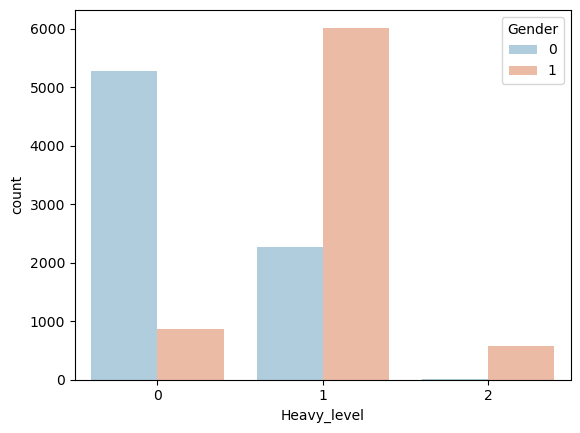

In [11]:
sns.countplot(x='Heavy_level',hue='Gender',data=df2,palette='RdBu_r')

### 男的平均卡路里消耗

In [13]:
male_avg_calories = df2[df2["Gender"] == 1]["Calories"].mean()
print("男性的平均卡路里消耗:", male_avg_calories)
female_avg_calories = df2[df2["Gender"] == 0]["Calories"].mean()
print("女性的平均卡路里消耗:", female_avg_calories)

男性的平均卡路里消耗: 90.94574996642943
女性的平均卡路里消耗: 88.1530517675096


結合前面所說，男性的身高體重大於女性，加上這裡的平均卡路里消耗也是男性大於女性，所以推測身高體重跟卡路里有相關

### 皮爾遜相關係數(coefficient)

In [16]:
def coefficient(x, y):
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # print(x_mean)
    # print(y_mean)
    
    xi_x = [v - x_mean for v in x]
    yi_y = [v - y_mean for v in y]
    
    dataxy =[0]*len(x)
    datax =[0]*len(x)
    datay =[0]*len(x)
    
    for i in range(len(x)):
        dataxy[i] = xi_x[i]*yi_y[i]
        datax[i] = xi_x[i]**2
        datay[i] = yi_y[i]**2
    
    txy = np.sum(dataxy)
    tx = np.sum(datax)
    ty = np.sum(datay)
      
    r = txy/((tx**0.5)*(ty**0.5))
    print(f"皮爾遜相關係數(coefficient) = {r}")

In [17]:
for i in df2.columns[1:]:
    if i != "Calories":
        print(f"{i}跟Calories")
        coefficient(df2[i],df2.Calories)

Age跟Calories
皮爾遜相關係數(coefficient) = 0.15439513134100114
Height跟Calories
皮爾遜相關係數(coefficient) = 0.01753676787479605
Weight跟Calories
皮爾遜相關係數(coefficient) = 0.035480581868321474
Duration跟Calories
皮爾遜相關係數(coefficient) = 0.955420533474268
Heart_Rate跟Calories
皮爾遜相關係數(coefficient) = 0.8978820606388281
Body_Temp跟Calories
皮爾遜相關係數(coefficient) = 0.824557757719224
Heavy_level跟Calories
皮爾遜相關係數(coefficient) = 0.04745006754218359
Burn_level跟Calories
皮爾遜相關係數(coefficient) = 0.8586037385176808


這裡經過計算皮爾遜相關係數可以得知上面的推測，身高體重跟卡路里有相關是錯誤的
#### Duration	Heart_Rate	Body_Temp 這三個資料才是影響卡路里的特徵

### 將資料normalization歸一化

In [20]:
def normalization(d):
    df2[d] = (df2[d] - df2[d].min())/(df2[d].max() - df2[d].min())

In [21]:
for i in df2.columns[1:-3]:
    normalization(i)
df2

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Heavy_level,Burn_level
0,1,0.813559,0.676768,0.604167,0.965517,0.622951,0.840909,231.0,1,1
1,0,0.000000,0.434343,0.250000,0.448276,0.442623,0.727273,66.0,0,0
2,1,0.830508,0.565657,0.447917,0.137931,0.344262,0.363636,26.0,1,0
3,0,0.237288,0.565657,0.364583,0.413793,0.540984,0.772727,71.0,0,0
4,0,0.118644,0.313131,0.229167,0.310345,0.229508,0.613636,35.0,1,0
...,...,...,...,...,...,...,...,...,...,...
14995,0,0.000000,0.707071,0.520833,0.344828,0.409836,0.750000,45.0,0,0
14996,0,0.118644,0.424242,0.302083,0.172414,0.295082,0.477273,23.0,0,0
14997,0,0.389831,0.363636,0.229167,0.517241,0.377049,0.681818,75.0,0,0
14998,1,0.983051,0.707071,0.635417,0.034483,0.278689,0.272727,11.0,1,0


### 也可以使用sklearn裡面的模組Min-Max Normaliaztion(歸一化)

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler().fit(df2)
df3 = scaler.transform(df2)
df3 = pd.DataFrame(df3)
df3.columns = df2.columns
df3

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Heavy_level,Burn_level
0,1.0,0.813559,0.676768,0.604167,0.965517,0.622951,0.840909,0.734824,0.5,1.0
1,0.0,0.000000,0.434343,0.250000,0.448276,0.442623,0.727273,0.207668,0.0,0.0
2,1.0,0.830508,0.565657,0.447917,0.137931,0.344262,0.363636,0.079872,0.5,0.0
3,0.0,0.237288,0.565657,0.364583,0.413793,0.540984,0.772727,0.223642,0.0,0.0
4,0.0,0.118644,0.313131,0.229167,0.310345,0.229508,0.613636,0.108626,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.000000,0.707071,0.520833,0.344828,0.409836,0.750000,0.140575,0.0,0.0
14996,0.0,0.118644,0.424242,0.302083,0.172414,0.295082,0.477273,0.070288,0.0,0.0
14997,0.0,0.389831,0.363636,0.229167,0.517241,0.377049,0.681818,0.236422,0.0,0.0
14998,1.0,0.983051,0.707071,0.635417,0.034483,0.278689,0.272727,0.031949,0.5,0.0


### 計算cosine_similarity

In [26]:
def cosine_similarity(x,y):
    return np.dot(x,y) / (np.sqrt(np.dot(x,x)) * np.sqrt(np.dot(y,y)))

In [27]:
for i in df3.columns[1:]:
    if i != "Calories":
        print(f"{i} & Calories cosine_similarity = ", cosine_similarity(df3[i],df3.Calories))

Age & Calories cosine_similarity =  0.7084487173782427
Height & Calories cosine_similarity =  0.7901952031775623
Weight & Calories cosine_similarity =  0.7697379348170812
Duration & Calories cosine_similarity =  0.9827831055122113
Heart_Rate & Calories cosine_similarity =  0.9394487172995619
Body_Temp & Calories cosine_similarity =  0.911956949298
Heavy_level & Calories cosine_similarity =  0.6299698895131756
Burn_level & Calories cosine_similarity =  0.9011906424179847


計算結果也與皮爾森係數相符 Duration、Heart_Rate、Body_Temp 與 Calories 較為相關

# 讀取資料

In [30]:
df2

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Heavy_level,Burn_level
0,1,0.813559,0.676768,0.604167,0.965517,0.622951,0.840909,231.0,1,1
1,0,0.000000,0.434343,0.250000,0.448276,0.442623,0.727273,66.0,0,0
2,1,0.830508,0.565657,0.447917,0.137931,0.344262,0.363636,26.0,1,0
3,0,0.237288,0.565657,0.364583,0.413793,0.540984,0.772727,71.0,0,0
4,0,0.118644,0.313131,0.229167,0.310345,0.229508,0.613636,35.0,1,0
...,...,...,...,...,...,...,...,...,...,...
14995,0,0.000000,0.707071,0.520833,0.344828,0.409836,0.750000,45.0,0,0
14996,0,0.118644,0.424242,0.302083,0.172414,0.295082,0.477273,23.0,0,0
14997,0,0.389831,0.363636,0.229167,0.517241,0.377049,0.681818,75.0,0,0
14998,1,0.983051,0.707071,0.635417,0.034483,0.278689,0.272727,11.0,1,0


## LinearRegression

導入模型

In [33]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

切割訓練集與測試集

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df2[['Age', 'Height', 'Weight', 'Duration','Heart_Rate','Body_Temp']], df2[['Calories']], test_size=0.2)

In [36]:
X_train.shape

(12000, 6)

In [37]:
y_train.shape

(12000, 1)

訓練

In [39]:
regr.fit(X_train,y_train)

LinearRegression()

預測

In [41]:
Y_train = regr.predict(X_train)
Y_test = regr.predict(X_test)

評分

In [43]:
mse = np.sum((Y_train-y_train)**2) / len(y_train)
print(mse)

Calories    126.140791
dtype: float64


In [44]:
W=regr.coef_
b=regr.intercept_
print(W)
print(b)

[[ 29.70420257 -15.17509162  22.85979918 192.95061478 121.46183091
  -75.41328798]]
[-26.69266776]


In [45]:
#載入迴歸常見的評估指標套件
from sklearn import metrics

In [46]:
MAE = metrics.mean_absolute_error(y_train, Y_train)
MSE = metrics.mean_squared_error(y_train, Y_train)
RMSE = metrics.root_mean_squared_error(y_train, Y_train)

print("MAE =  ", MAE)
print("MSE = ", MSE)
print("RMSE = ", RMSE)

MAE =   8.25288800163243
MSE =  126.14079122171334
RMSE =  11.231241748876807


In [47]:
MAE = metrics.mean_absolute_error(y_test, Y_test)
MSE = metrics.mean_squared_error(y_test, Y_test)
RMSE = metrics.root_mean_squared_error(y_test, Y_test)

print("MAE =  ", MAE)
print("MSE = ", MSE)
print("RMSE = ", RMSE)

MAE =   8.712644826203492
MSE =  135.865459981752
RMSE =  11.656134006683004


In [48]:
train_score=regr.score(X_train, y_train)
test_score=regr.score(X_test, y_test)
print("linear regression train score:", train_score)
print("linear regression test score:", test_score)

linear regression train score: 0.9675462134996523
linear regression test score: 0.9656314936706022


### 比較 LinearRegression Ridge Lasso

In [50]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

ridge regression train score alpha = 1: 0.9675339914088603
ridge regression test score alpha = 1: 0.965644128036416
----------------------------------------------------------------------------------------------------
ridge regression train score alpha = 0.01: 0.9675462122163592
ridge regression test score alpha = 0.01: 0.9656317415719204
----------------------------------------------------------------------------------------------------
ridge regression train score alpha = 100: 0.9488831221612601
ridge regression test score alpha = 100: 0.9480217778890356
----------------------------------------------------------------------------------------------------


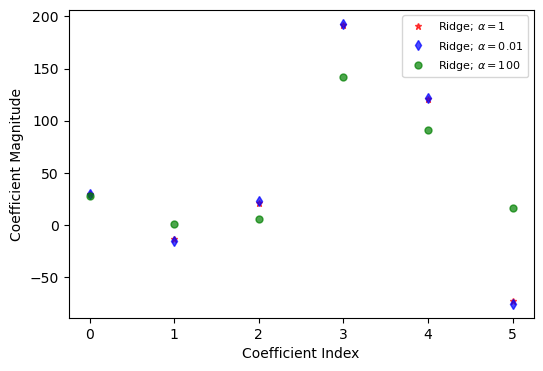

In [51]:
def ridge(n):
    rr = Ridge(alpha=n)
    rr.fit(X_train, y_train)
    
    Ridge_train_score = rr.score(X_train,y_train)
    Ridge_test_score = rr.score(X_test, y_test)
    
    print(f"ridge regression train score alpha = {n}:", Ridge_train_score)
    print(f"ridge regression test score alpha = {n}:", Ridge_test_score)
    print('-'*100)

    return np.ravel(rr.coef_)
    

r1 = ridge(1)
r001 = ridge(0.01)
r100 = ridge(100)

plt.figure(figsize=(6, 4))
plt.plot(r1,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 1$')
plt.plot(r001,alpha=0.7,linestyle='none',marker='d',markersize=5,color='blue',label=r'Ridge; $\alpha = 0.01$')
plt.plot(r100,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label=r'Ridge; $\alpha = 100$')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(fontsize=8,loc=1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


training score for alpha= 1: 0.9414422419145766
test score for alpha = 1:  0.9402734078482456
number of features used: for alpha = 1: 3
----------------------------------------------------------------------------------------------------
training score for alpha= 0.01: 0.9674753019597017
test score for alpha = 0.01:  0.9655693808802968
number of features used: for alpha = 0.01: 6
----------------------------------------------------------------------------------------------------
training score for alpha= 0.0001: 0.967546206063672
test score for alpha = 0.0001:  0.9656315459695578
number of features used: for alpha = 0.0001: 6
----------------------------------------------------------------------------------------------------


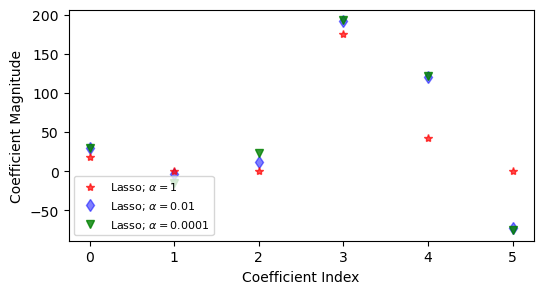

In [52]:
def lasso_(n):
    lasso = Lasso(alpha=n, max_iter=1000000)
    lasso.fit(X_train,y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    print(f"training score for alpha= {n}:", train_score )
    print(f"test score for alpha = {n}: ", test_score)
    print(f"number of features used: for alpha = {n}:", coeff_used)
    print('-'*100)

    return lasso.coef_
    
la1 = lasso_(1)
la001 = lasso_(0.01)
la00001 = lasso_(0.0001)

plt.figure(figsize=(6, 3))
plt.xlabel('Coefficient Index',fontsize=10)
plt.ylabel('Coefficient Magnitude',fontsize=10)
plt.legend(fontsize=8,loc=3)

plt.plot(la1,alpha=0.7,linestyle='none',marker='*',markersize=6,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) 
plt.plot(la001,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') 
plt.plot(la00001,alpha=0.8,linestyle='none',marker='v',markersize=6,color='green',label=r'Lasso; $\alpha = 0.0001$') 
plt.legend(fontsize=8,loc=3)
plt.show()

## Logistic Regression 
使用Logistic Regression 透過 Duration、Heart_Rate、Body_Temp 來訓練模型預測 Burn_level

In [54]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    df2[['Duration','Heart_Rate', 'Body_Temp']], df2[['Burn_level']], test_size=0.3, random_state=0)

In [55]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train,y_train['Burn_level'].values)

LogisticRegression()

In [56]:
Y_train = lr.predict(X_train)

In [57]:
error = 0
for i, v in enumerate(Y_train):
    if v!= y_train['Burn_level'].values[i]:
        error+=1
print('the number of errors(train):',error)
print('train accuracy:',1-error/len(X_train))

the number of errors(train): 407
train accuracy: 0.9612380952380952


In [58]:
Y_test = lr.predict(X_test)

In [59]:
error = 0
for i, v in enumerate(lr.predict(X_test)):
    if v!= y_test['Burn_level'].values[i]:
        error+=1
print('the number of errors(test):',error)
print('test accuracy:',1-error/len(X_test))

the number of errors(test): 191
test accuracy: 0.9575555555555556


####  Standardization

In [61]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
sc = StandardScaler().fit(X_test)
X_test_std = sc.transform(X_test)

In [62]:
lr2 = LogisticRegression(solver='lbfgs')
lr2.fit(X_train_std,y_train['Burn_level'].values)

LogisticRegression()

In [63]:
lr2.predict(X_train_std)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [64]:
error_std = 0
for i, v in enumerate(lr.predict(X_train_std)):
    if v!= y_train['Burn_level'].values[i]:
        error_std += 1
print('the number of errors(train):',error_std)
print('train accuracy:',1-error_std/len(X_train_std))

the number of errors(train): 873
train accuracy: 0.9168571428571428


In [65]:
lr2.predict(X_test_std)

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [66]:
error_std = 0
for i, v in enumerate(lr.predict(X_test_std)):
    if v!= y_test['Burn_level'].values[i]:
        error_std += 1
print('the number of errors(test):',error_std)
print('test accuracy:',1-error_std/len(X_test_std))

the number of errors(test): 386
test accuracy: 0.9142222222222223


## KNN
n_neighbors就是k值  p試算距離的方式    
p: 1→曼哈頓距離 / 2→歐基里德距離 / 其他: 明氏距離   
透過 Height、Weight 來預測 Heavy_level

In [68]:
from sklearn.neighbors import KNeighborsClassifier

使用還沒有經過normaliaztion的Height、Weight來預測

In [185]:
X_train, X_test, y_train, y_test = train_test_split(df[['Height', 'Weight']], df2[['Heavy_level']],test_size=0.3)

訓練

In [188]:
clf=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance',algorithm='brute') 
clf.fit(X_train,y_train) 

KNeighborsClassifier(algorithm='brute', n_neighbors=3, weights='distance')

In [189]:
clf.predict(X_test)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [192]:
clf.score(X_train,y_train)

1.0

In [193]:
clf.score(X_test,y_test)

0.9973333333333333

找尋最佳KNN裡的K值

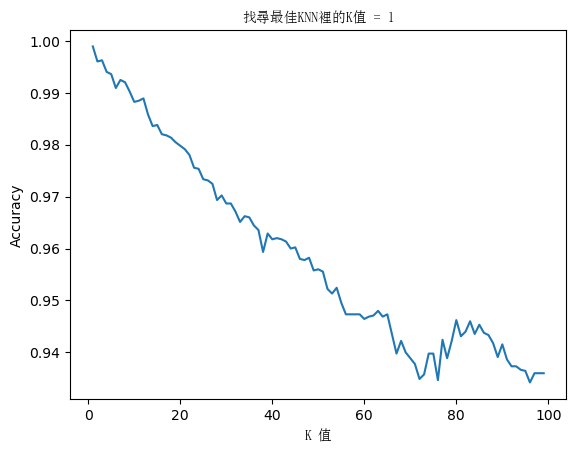

In [160]:
accuracy = []
k_max = 0
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train, y_train)                 
    y_pred = knn.predict(X_test)             
    score = metrics.accuracy_score(y_test, y_pred)
    accuracy.append(score) 
    if score == max(accuracy):
        k_max = k
        
k_range = range(1,100)
plt.plot(k_range, accuracy)
plt.title(f"找尋最佳KNN裡的K值 = {k_max}", fontproperties="SimSun")
plt.xlabel("K 值", fontproperties="SimSun")
plt.ylabel("Accuracy")
plt.show()

視覺化

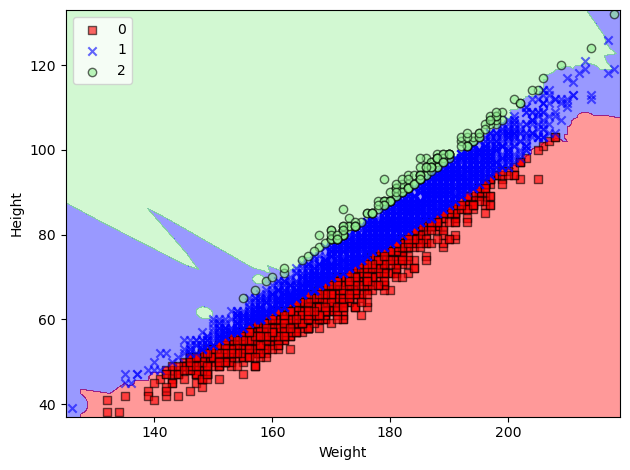

In [197]:
plot_decision_regions(X_test.values, y_test['Heavy_level'].values, classifier=clf)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## SVM

In [201]:
from sklearn import svm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['Height', 'Weight']], df2[['Heavy_level']],test_size=0.5,random_state=0)

C: 懲罰係數，C愈大代表容忍錯誤的程度愈低，愈容易造成過度擬和的問題  <br> 
gamma: 決定支援向量的多寡，影響訓練速度與預測速 ('scale','auto'<br>   )
kernel: 決定不同的核函數，如: linear, poly, rbf, sigmoid等等

In [ ]:
clf=svm.SVC(kernel='poly',gamma='auto',C=100)
clf.fit(X_train,y_train)

In [ ]:
clf.predict(X_test)

In [ ]:
print(clf.score(X_train,y_train))
print(clf.score(X_test, y_test))